Upload a grayscale or binary image:


Saving 11.jpeg to 11.jpeg


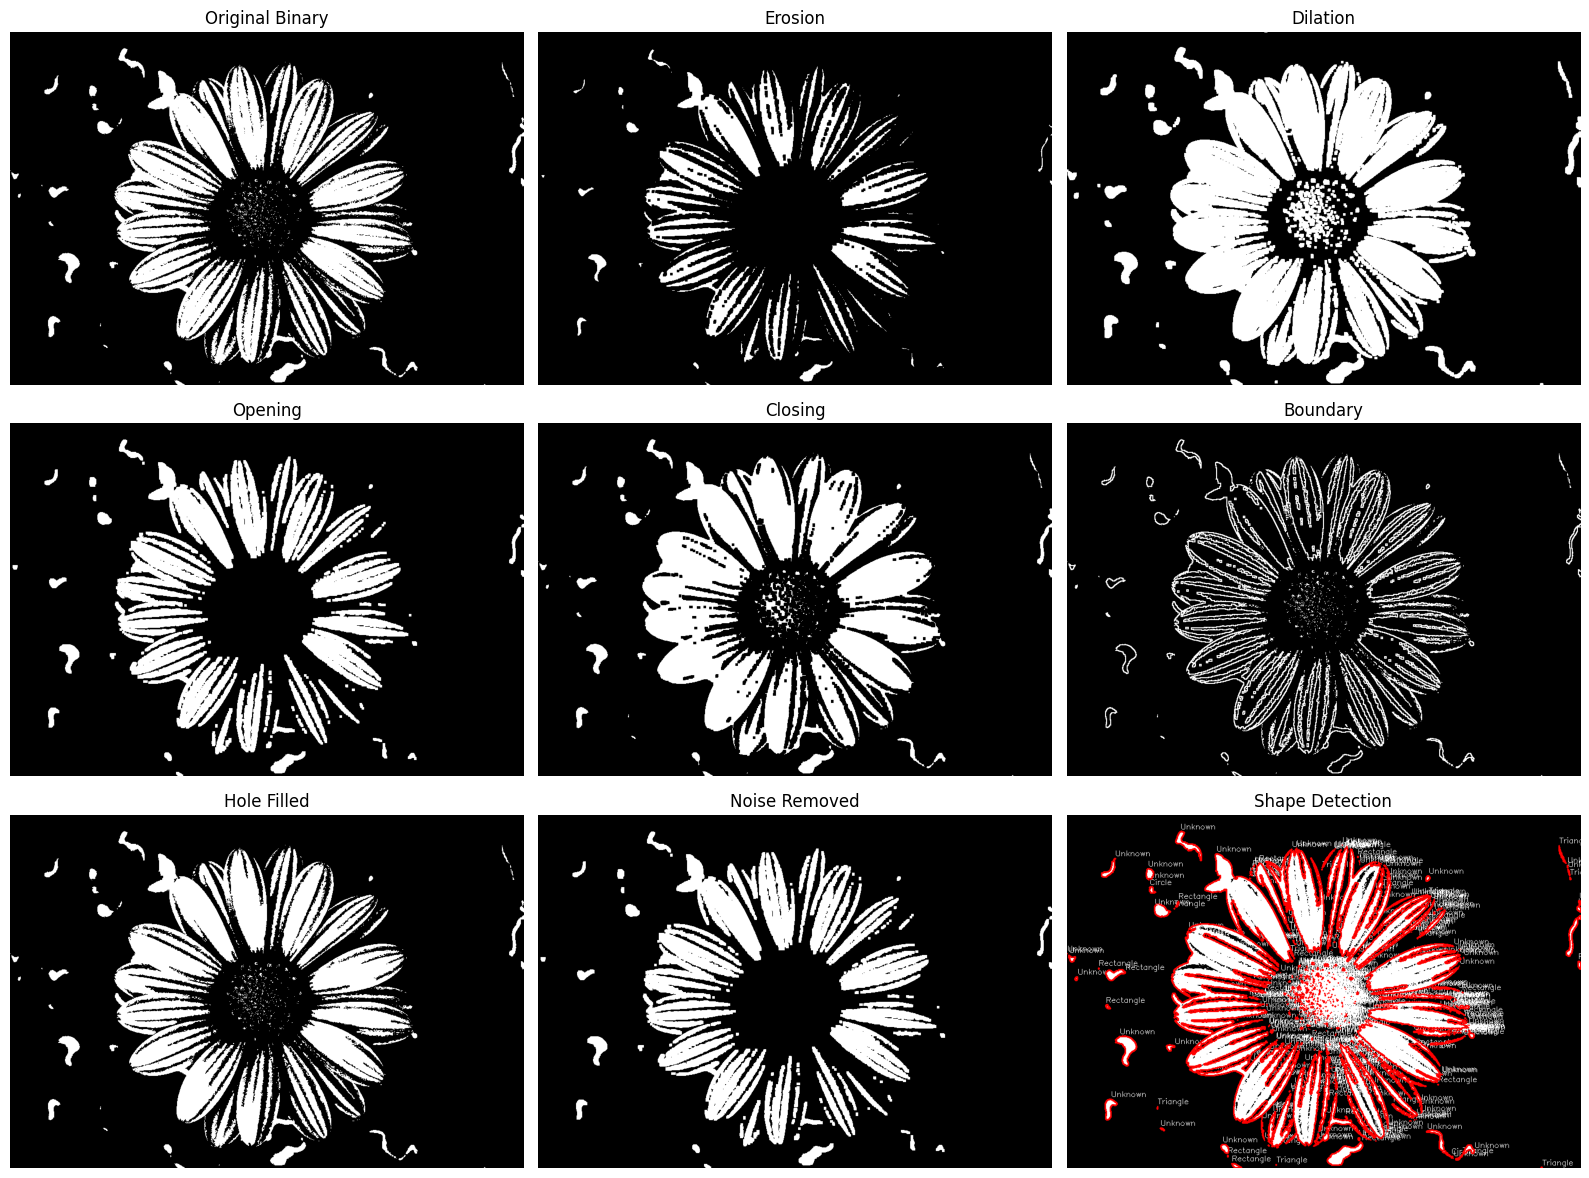

In [3]:
# =========================================
# LAB 11 – MORPHOLOGICAL OPERATIONS (Improved)
# =========================================

from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# IMAGE UPLOAD
# ------------------------------
print("Upload a grayscale or binary image:")
uploaded = files.upload()
image_name = next(iter(uploaded))

# Read image as grayscale
img = cv2.imread(image_name, cv2.IMREAD_GRAYSCALE)

# ------------------------------
# CONVERT TO BINARY
# ------------------------------
def convert_to_binary(image, threshold=127):
    _, binary = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)
    return binary

binary = convert_to_binary(img)

# ------------------------------
# MORPHOLOGICAL OPERATIONS
# ------------------------------
def morphological_operations(image, kernel_size=5, iterations=1):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    erosion = cv2.erode(image, kernel, iterations=iterations)
    dilation = cv2.dilate(image, kernel, iterations=iterations)
    opening = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    noise_removed = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
    return erosion, dilation, opening, closing, noise_removed

erosion, dilation, opening, closing, noise_removed = morphological_operations(binary)

# ------------------------------
# BOUNDARY EXTRACTION
# ------------------------------
def extract_boundary(image, erosion_img):
    boundary = image - erosion_img
    return boundary

boundary = extract_boundary(binary, erosion)

# ------------------------------
# HOLE FILLING USING RECONSTRUCTION
# ------------------------------
def fill_holes(image, kernel_size=5):
    inv = cv2.bitwise_not(image)
    marker = np.zeros_like(inv)
    marker[0, :] = inv[0, :]
    marker[-1, :] = inv[-1, :]
    marker[:, 0] = inv[:, 0]
    marker[:, -1] = inv[:, -1]

    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    prev = marker.copy()
    while True:
        dilated = cv2.dilate(prev, kernel)
        reconstructed = cv2.min(dilated, inv)
        if np.array_equal(reconstructed, prev):
            break
        prev = reconstructed

    filled = cv2.bitwise_not(reconstructed)
    return filled

filled = fill_holes(binary)

# ------------------------------
# SHAPE DETECTION
# ------------------------------
def detect_shapes(image):
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    shape_img = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    for cnt in contours:
        approx = cv2.approxPolyDP(cnt, 0.04 * cv2.arcLength(cnt, True), True)
        if len(approx) == 3:
            shape = "Triangle"
        elif len(approx) == 4:
            shape = "Rectangle"
        elif len(approx) > 6:
            shape = "Circle"
        else:
            shape = "Unknown"
        cv2.drawContours(shape_img, [cnt], -1, (0, 0, 255), 2)
        x, y = approx[0][0]
        cv2.putText(shape_img, shape, (x, y-5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    return shape_img

shape_img = detect_shapes(binary)

# ------------------------------
# DISPLAY ALL RESULTS
# ------------------------------
titles = [
    "Original Binary", "Erosion", "Dilation",
    "Opening", "Closing", "Boundary",
    "Hole Filled", "Noise Removed", "Shape Detection"
]

images = [
    binary, erosion, dilation,
    opening, closing, boundary,
    filled, noise_removed, shape_img
]

plt.figure(figsize=(16,12))
for i, img_out in enumerate(images):
    plt.subplot(3,3,i+1)
    if len(img_out.shape) == 2:
        plt.imshow(img_out, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(img_out, cv2.COLOR_BGR2RGB))
    plt.title(titles[i])
    plt.axis('off')

plt.tight_layout()
plt.show()